In [1]:
import matplotlib
import cv2
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pathlib

Using TensorFlow backend.


In [2]:
from PIL import Image
data = []
labels = []
random.seed(1234)

#берём пути к изображениям и рандомно перемешиваем
data_root = pathlib.Path("C:\\UIR\\samples\\sample_2\\2250\\cut_letters")
imagePaths = list(data_root.glob('*/*'))
imagePaths = [str(path) for path in imagePaths]
random.shuffle(imagePaths)

#цикл по изображениям
for imagePath in imagePaths:
    #загружаем изображение, меняем размер на 28x28 пикселей и добавляем в список
    image = cv2.imread(imagePath)
    image = cv2.resize(image,(28,28))
    data.append(image)
    
    #извлекаем метку класса из пути к изображению и обновляем список меток
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [3]:
# масштабируем интенсивности пикселей из диапазона [0,255] -> в диапазон [0, 1]
data = np.array(data,dtype="float") / 255.0
labels = np.array(labels)

In [4]:
# разбиваем данные на обучающую и тестовую выборки, используя 75% 
# данных для обучения и оставшиеся 25% для тестирования
(trainX,testX, trainY,testY) = train_test_split(data, labels, test_size = 0.25, random_state = 42)
print(testX.shape)
print(trainX.shape)

(21000, 28, 28, 3)
(63000, 28, 28, 3)


In [5]:
#Конвертируем метки из целых чисел в векторы
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY) #находит все уникальные метки класса в testY, а затем преобразует их в метки One-Hot Encoding
testY = lb.transform(testY) #выполняет один шаг One-Hot Encoding исходя из найденных уникальных меток на предыдущем шаге

In [6]:
print('X_train shape:', trainX.shape)
print(trainX.shape[0], 'train samples')
print(testX.shape[0], 'test samples')

X_train shape: (63000, 28, 28, 3)
63000 train samples
21000 test samples


## CNN Architecture

In [7]:
EPOCHS = 30
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 3) #input_shape будет равен 28x28x3
num_classes = 28


model = Sequential()
model.add(Conv2D(filters=50,kernel_size=(3, 3),strides=(1, 1), activation='sigmoid', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Conv2D(filters=70,kernel_size=(3, 3),strides=(1, 1), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Flatten())
model.add(Dense(300, activation='sigmoid'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#Компилируем модель, используя adadelta как оптимизатор и категориальную
# кросс-энтропию в качестве функции потерь. Добавляем метрики
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [8]:
#отобразим получившуюся модель
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 50)        1400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 70)        31570     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 70)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1750)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               525300    
_________________________________________________________________
dense_2 (Dense)              (None, 28)               

In [9]:
#подключаем колбаски для работы tensorboard
#write tensorboard --logdir C:/UIR/network_2_26/logs in cmd

from keras import callbacks
checkpoint_filepath = 'C:\\UIR\\network_2_26\\checkpoints'

my_callbacks = [
    # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
    #callbacks.EarlyStopping(monitor='val_loss', patience=3), #возможно val_loss -> loss
    callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_acc',mode='max',save_best_only=True),
    callbacks.TensorBoard(log_dir="C:\\UIR\\network_2_26\\logs", histogram_freq = 1, write_graph = True, write_images = True)
]
# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)

In [10]:
H = model.fit(trainX, trainY, verbose=2, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32, callbacks=my_callbacks)

Train on 63000 samples, validate on 21000 samples
Epoch 1/30
 - 83s - loss: 0.4676 - accuracy: 0.8794 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/30


c:\users\super\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 87s - loss: 8.5541e-04 - accuracy: 1.0000 - val_loss: 6.7072e-04 - val_accuracy: 1.0000
Epoch 3/30
 - 85s - loss: 4.2267e-04 - accuracy: 1.0000 - val_loss: 3.1812e-04 - val_accuracy: 1.0000
Epoch 4/30
 - 83s - loss: 2.7655e-04 - accuracy: 1.0000 - val_loss: 2.2786e-04 - val_accuracy: 1.0000
Epoch 5/30
 - 88s - loss: 2.0468e-04 - accuracy: 1.0000 - val_loss: 1.7760e-04 - val_accuracy: 1.0000
Epoch 6/30
 - 85s - loss: 1.6140e-04 - accuracy: 1.0000 - val_loss: 1.4207e-04 - val_accuracy: 1.0000
Epoch 7/30
 - 81s - loss: 1.3389e-04 - accuracy: 1.0000 - val_loss: 1.1966e-04 - val_accuracy: 1.0000
Epoch 8/30
 - 80s - loss: 1.1364e-04 - accuracy: 1.0000 - val_loss: 1.0410e-04 - val_accuracy: 1.0000
Epoch 9/30
 - 80s - loss: 9.9117e-05 - accuracy: 1.0000 - val_loss: 9.0190e-05 - val_accuracy: 1.0000
Epoch 10/30
 - 82s - loss: 8.7334e-05 - accuracy: 1.0000 - val_loss: 8.0542e-05 - val_accuracy: 1.0000
Epoch 11/30
 - 81s - loss: 7.8101e-05 - accuracy: 1.0000 - val_loss: 7.2612e-05 - val_accura

In [11]:
model.save('model_2_26.h5')
f = open("C:\\UIR\\network_2_26\\bin_class.txt", "wb")
f.write(pickle.dumps(lb))
f.close()

## Plots

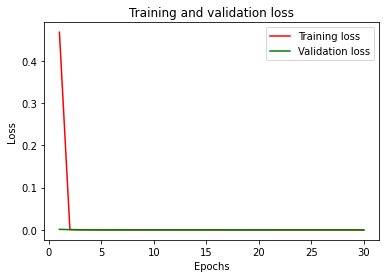

In [12]:
#plotting training and validation loss
import matplotlib.pyplot as plt
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

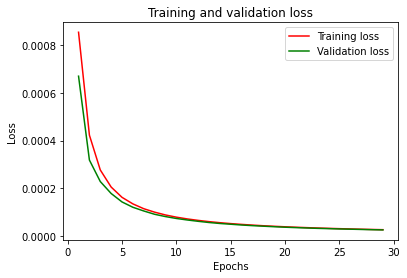

In [13]:
#plotting training and validation loss
import matplotlib.pyplot as plt
loss = H.history['loss']
loss = loss[1:]
val_loss = H.history['val_loss']
val_loss = val_loss[1:]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

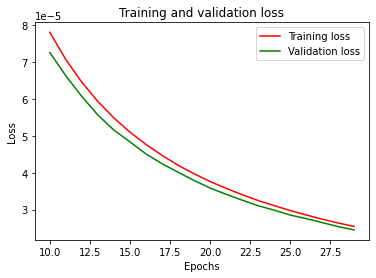

In [17]:
#plotting training and validation loss
import matplotlib.pyplot as plt
loss = H.history['loss']
loss = loss[10:]
val_loss = H.history['val_loss']
val_loss = val_loss[10:]
epochs = range(10, len(loss) + 10)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

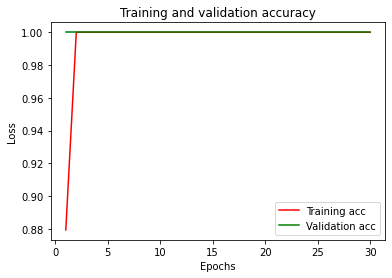

In [18]:
#plotting training and validation accuracy
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

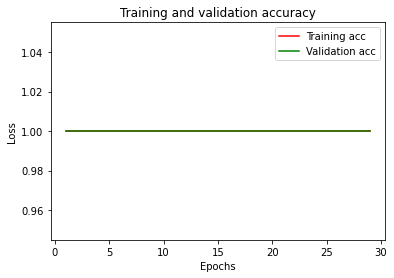

In [19]:
#plotting training and validation accuracy
acc = H.history['accuracy']
acc = acc[1:]
val_acc = H.history['val_accuracy']
val_acc = val_acc[1:]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(trainX[5].reshape(1,28,28,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
        

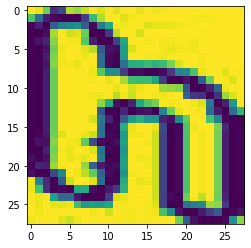

In [22]:
plt.imshow(trainX[5][:,:,0]);

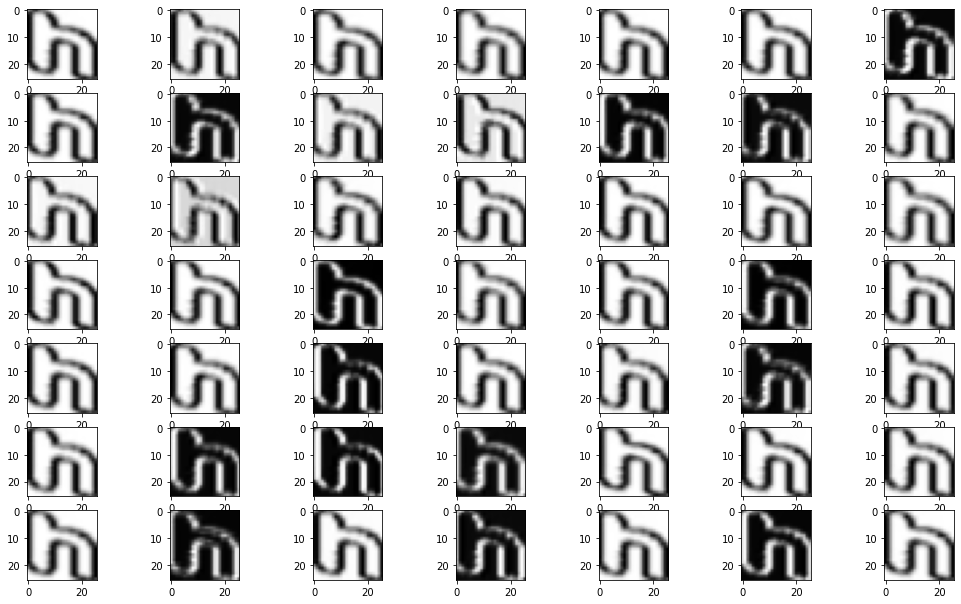

In [23]:
display_activation(activations, 7, 7, 0) #Desplaying above image after layer 1

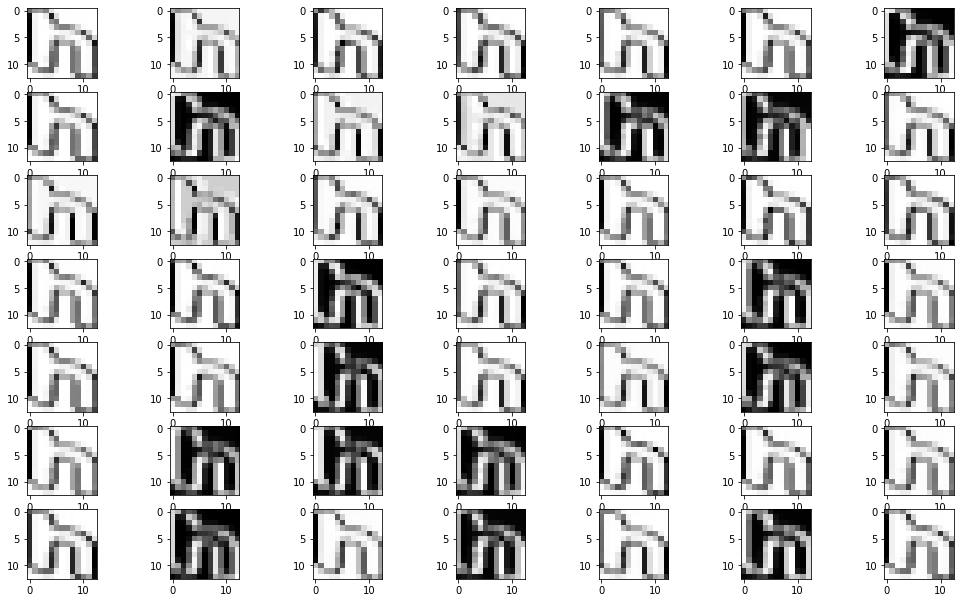

In [24]:
display_activation(activations, 7, 7, 1) #Desplaying above image after layer 2

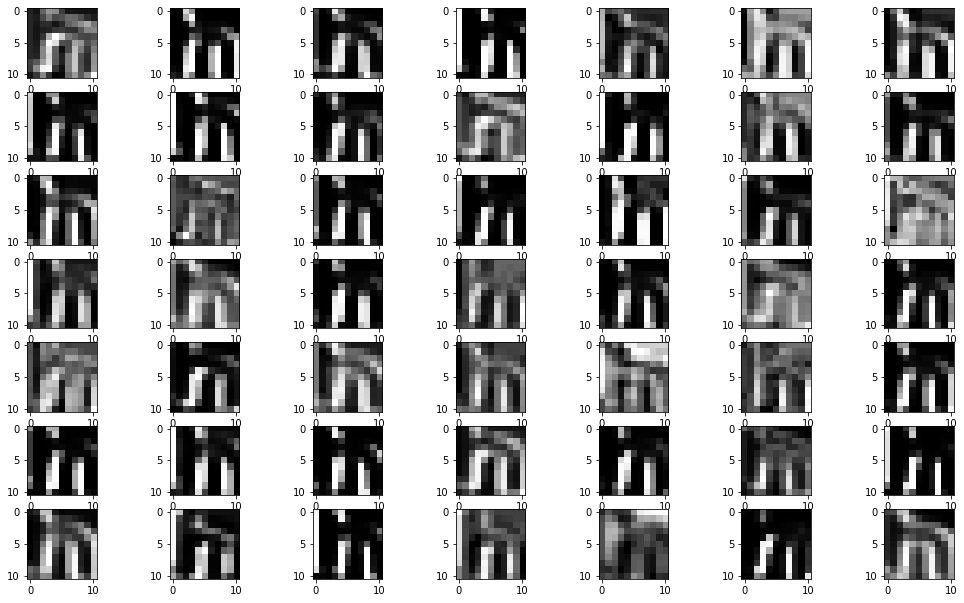

In [25]:
display_activation(activations, 7, 7, 2) #Desplaying above image after layer 3

IndexError: too many indices for array

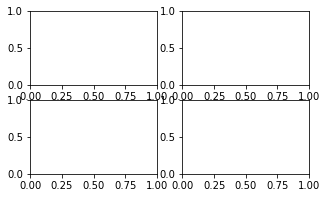

In [27]:
display_activation(activations, 7, 7, 4) #Desplaying above image after layer 4

In [29]:
PATH = "C:\\UIR\\site\\pic\\3.jpeg"

test_image = cv2.imread(PATH)
test_image = cv2.resize(test_image,(28,28))
cv2.imshow('image',test_image)
cv2.waitKey(0)
test_image = test_image.astype("float") / 255.0
test_image = test_image.reshape((1,test_image.shape[0], test_image.shape[1],test_image.shape[2]))
preds = model.predict(test_image)
i = preds.argmax(axis=1)[0]
test_label = lb.classes_[i]
print("Результат распознавания: " + test_label)
print(preds)

Результат распознавания: m
[[6.53659459e-04 1.78190101e-06 1.07942475e-03 3.86013817e-05
  8.99824721e-04 1.13361566e-04 1.47365136e-02 2.71550901e-02
  2.03296082e-07 2.15112623e-02 1.84260644e-02 3.89935394e-07
  1.57073792e-03 7.63564240e-05 2.52595753e-04 1.97777268e-03
  6.36331225e-03 5.95287769e-04 4.71202761e-01 1.88651844e-03
  1.30154623e-03 3.49981157e-04 3.86974402e-02 3.96184041e-05
  1.44391758e-02 3.64192963e-01 1.11102164e-02 1.32739602e-03]]


In [30]:
text = "{}: {:.2f}%".format(test_label, preds[0][i] * 100)
text

'm: 47.12%'

In [33]:
i

18